In [2]:
using PGFPlots
using StaticArrays
push!(LOAD_PATH, ("/home/kylebrown/Repositories/OldRoadways/src/"))
import Base: hash
using Vec
import curves
import splines
import utils
import roadways

# Some Excellent Spline Resources
http://www.cs.cornell.edu/courses/cs4620/2013fa/lectures/16spline-curves.pdf

# Spline Playground

In [3]:
struct Point2D{R<:Real} <: FieldVector{2,R}
    x::R
    y::R
end
StaticArrays.similar_type(p::Type{P}, ::Type{R}, size::Size{(2,)}) where {P<:Point2D, R<:Real} = Point2D{R}

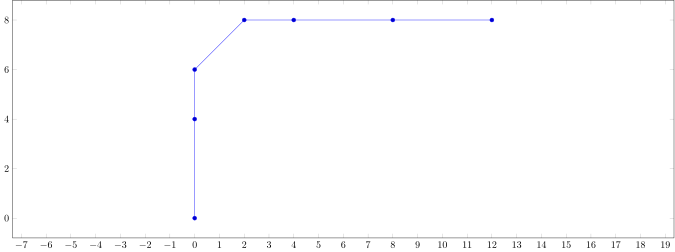

In [4]:
pts = Array{Float64}([
        0 0;
        0 4;
        0 6;
        2 8;
        4 8;
        8 8;
        12 8;
        ])'
P = [Point2D(pts[:,i]) for i in 1:size(pts)[2]];
Axis([
        Plots.Linear(pts[1,:],pts[2,:])
        ], axisEqual=true, width="25cm", height="10cm")

## Circle Splines
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.87.3282&rep=rep1&type=pdf

In [5]:
i = 3
a = normalize(P[i] .- P[i-1])
b = normalize(P[i+1] .- P[i])
c = normalize(P[i+1] .- P[i-1])
d = normalize(P[i+2] .- P[i+1])
e = normalize(P[i+2] .- P[i])

τi = acos(dot(a,c))
τj = acos(dot(e,d))

τ(u)  = τi*cos.(u*π/2).^2 + τj*sin.(u*π/2).^2
f(u) = norm(P[i+1] .- P[i]).*sin.(u.*τ(u)) ./ sin.(τ(u))  
ϕ(u) = (1.-u).*τ(u)

u = collect(linspace(0.0,1.0))

nPts = f(u) .* [cos.(atan2(b.y, b.x) + ϕ(u)) sin.(atan2(b.y, b.x) + ϕ(u))] .+ P[i]'

Axis([
        Plots.Linear(pts[1,:],pts[2,:]),
        Plots.Linear(nPts[:,1],nPts[:,2], mark="none")
        ], axisEqual=true, width="25cm", height="10cm")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


# Cubic Splines
http://mathworld.wolfram.com/CubicSpline.html

In [39]:
pts = [1;1] .+ [collect(0:10) sin.(collect(0:10)*.5)]'

2×11 Array{Float64,2}:
 1.0  2.0      3.0      4.0      5.0     …  9.0       10.0        11.0      
 1.0  1.47943  1.84147  1.99749  1.9093     0.243198   0.0224699   0.0410757

In [7]:
N = 40
Δs = 0.1

d,n = size(pts)
n -= 1

M = spzeros(n+1,n+1)
for i = 1 : n
    M[i,i] = 4
    M[i,i+1] = 1
    M[i+1,i] = 1
end
M[n+1,n+1] = 2
M[1,1] = 2

Y = Array{Float64}(n+1)
for i = 1 : n+1
    ind_hi = min(i+1,n+1)
    ind_lo = max(1,i-1)
    Y[i] = 3*(pts[ind_hi] - pts[ind_lo])
end

M = vcat(M, 5*[-eye(n) zeros(n,1)] .+ [zeros(n,1) eye(n)])
Y = vcat(Y,zeros(n))

spline_coeffs = Array{Matrix{Float64}}(d)
for k in 1 : d

    for i in 1 : n+1
        ind_hi = min(i+1,n+1)
        ind_lo = max(1,i-1)
        Y[i] = 3*(pts[k,ind_hi] - pts[k,ind_lo])
    end

#     D = M \ Y
    
    D = M'*M \ (M'*Y)

    spline_coeffs[k] = Array{Float64}(4, n) # col is <a,b,c,d> for a + b⋅t + c⋅t² + d⋅t³
    spline_coeffs[k][1,:] = pts[k,1:n] # x₀
    spline_coeffs[k][2,:] = D[1:n]     # x'₀
    spline_coeffs[k][3,:] = 3*(pts[k,2:n+1] .- pts[k,1:n]) .- 2*D[1:n] .- D[2:n+1] # -3x₀ + 3x₁ - 2x'₀ - x'₁
    spline_coeffs[k][4,:] = 2*(pts[k,1:n] .- pts[k,2:n+1]) .+  D[1:n] .+ D[2:n+1] #  2x₀ - 2x₁ +  x'₀ + x'₁
end

L = calc_curve_length(spline_coeffs[1], spline_coeffs[2])
n = round(Int, L/Δs)+1

s_arr = collect(linspace(0.0,L,n))
t_arr = calc_curve_param_given_arclen(spline_coeffs[1], spline_coeffs[2], s_arr,
    curve_length=L)

x_arr = sample_spline(spline_coeffs[1], t_arr)
y_arr = sample_spline(spline_coeffs[2], t_arr)

cpts = _fit_curve(pts,Δs)
x = [pt.pos.x for pt in cpts]
y = [pt.pos.y for pt in cpts];

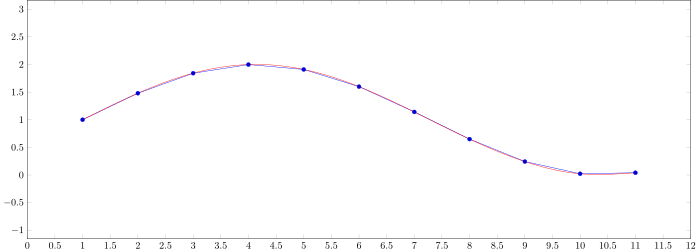

In [8]:
Axis([
        Plots.Linear(pts[1,:],pts[2,:]),
        Plots.Linear(x,y, mark="none")
        ], axisEqual=true, width="25cm", height="10cm")

# Circle Spline Approximation of Parametric Curve
https://pdfs.semanticscholar.org/f749/b6faca7c4486f8ede7aa633c494f37b3e86e.pdf

# B spline Basis Functions

In [40]:
t = collect(linspace(0,8,500))
b1(t) = 1.0*(0 .<= t .< 1.0)
b2(t) = (t/(2-1)).*b1(t) .+ ((2.-t)/(2-1)).*b1(t - 1.0)
b3(t) = (t/(3-1)).*b2(t) .+ ((3.-t)/(3-1)).*b2(t - 1.0)
b4(t) = (t/(4-1)).*b3(t) .+ ((4.-t)/(4-1)).*b3(t - 1.0)

b4 (generic function with 1 method)

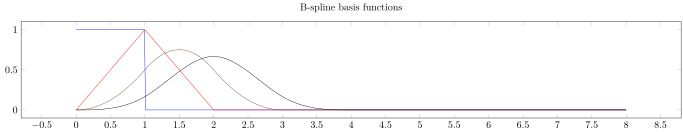

In [41]:
Axis([
        Plots.Linear(t, b1(t), mark="none"),
        Plots.Linear(t, b2(t), mark="none"),
        Plots.Linear(t, b3(t), mark="none"),
        Plots.Linear(t, b4(t), mark="none"),
        ], title="B-spline basis functions", width="25cm", height="5cm")

In [42]:
A1 = Axis([
        Plots.Linear(t, b1(t), mark="none"),
        Plots.Linear(t, b1(t-1.0), mark="none"),
        Plots.Linear(t, b1(t-2.0), mark="none"),
        Plots.Linear(t, b1(t-3.0), mark="none"),
        Plots.Linear(t, b1(t-4.0), mark="none"),
        ], title="b1", width="25cm", height="5cm");
A2 = Axis([
        Plots.Linear(t, b2(t), mark="none"),
        Plots.Linear(t, b2(t-1.0), mark="none"),
        Plots.Linear(t, b2(t-2.0), mark="none"),
        Plots.Linear(t, b2(t-3.0), mark="none"),
        Plots.Linear(t, b2(t-4.0), mark="none"),
        ], title="b2", width="25cm", height="5cm")
A3 = Axis([
        Plots.Linear(t, b3(t), mark="none"),
        Plots.Linear(t, b3(t-1.0), mark="none"),
        Plots.Linear(t, b3(t-2.0), mark="none"),
        Plots.Linear(t, b3(t-3.0), mark="none"),
        Plots.Linear(t, b3(t-4.0), mark="none"),
        ], title="b3", width="25cm", height="5cm")
A4 = Axis([
        Plots.Linear(t, b4(t), mark="none"),
        Plots.Linear(t, b4(t-1.0), mark="none"),
        Plots.Linear(t, b4(t-2.0), mark="none"),
        Plots.Linear(t, b4(t-3.0), mark="none"),
        Plots.Linear(t, b4(t-4.0), mark="none"),
        ], title="b4", width="25cm", height="5cm");

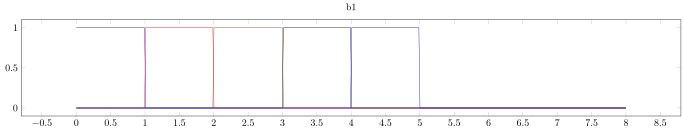

In [43]:
A1

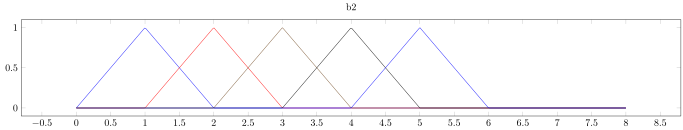

In [44]:
A2

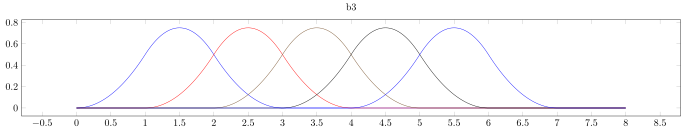

In [45]:
A3

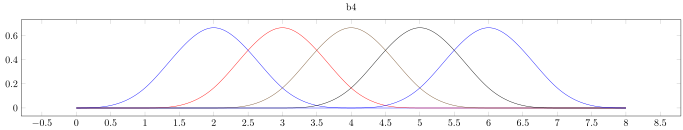

In [46]:
A4

In [47]:
Pts = pts
k = 4 # 4th order spline
d = k - 1 # 3rd degree splines
n = size(Pts,2) # number of control points

11

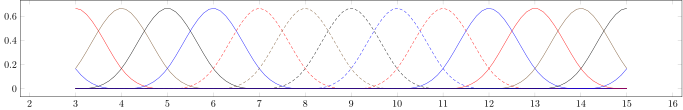

In [48]:
Pts = [repmat(pts[:,1],1,2) pts repmat(pts[:,end],1,2)]
t = collect(linspace(k/2+1,n+(d-1)*2,100))
M = hcat([b4(t-i) for i in 0:n+(d-1)*2-1]...)
spline = Pts*M'
Axis([
        Plots.Linear(t,b4(t-i), mark="none") for i in 0:n+(d-1)*2-1
        ], width="25cm", height="5cm")

In [49]:
knots = [0;0;collect(0:n-1);n;n]

15-element Array{Int64,1}:
  0
  0
  0
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 11

In [50]:
sample_spline(t,pts) = pts * b4(t-collect(0:size(pts)[2]-1))

sample_spline (generic function with 5 methods)

In [51]:
sample_spline(4+3,Pts)

2-element Array{Float64,1}:
 4.0    
 1.95679

In [52]:
(pts[:,3]+pts[:,5])/6 + (2/3)*pts[:,4] # spline pt for which the ith basis function is at its maximum (2/3)

2-element Array{Float64,1}:
 4.0    
 1.95679

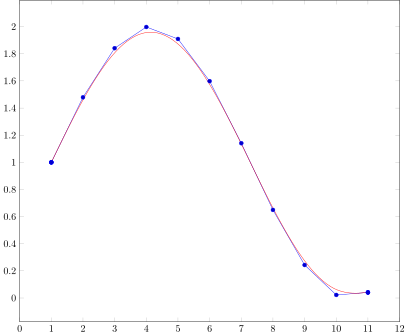

In [53]:
Axis([
        Plots.Linear(Pts[1,:],Pts[2,:])
        Plots.Linear(spline[1,:],spline[2,:],mark="none")
        ],width="15cm")

In [54]:
knots = Array{Float64}([0;0;collect(0:n-1);n;n])
tval = 2.5
idx = 1
for i in 1:length(knots)-1
    if knots[i] <= tval < knots[i+1]
        idx = i
        break
    end
end
eval_pts = Pts[:,idx-2:idx+2]
p = eval_pts*b4(tval + idx-1 .- collect(-2:2))

2-element Array{Float64,1}:
 0.0
 0.0

# Convex hull property of cubic splines?

In [55]:
pts = [collect(1:11) zeros(length(1:11))]'
pts[2,6] = 1.0

1.0

In [56]:
N = 40
Δs = 0.1

d,n = size(pts)
n -= 1

M = spzeros(n+1,n+1)
for i = 1 : n
    M[i,i] = 4
    M[i,i+1] = 1
    M[i+1,i] = 1
end
M[n+1,n+1] = 2
M[1,1] = 2

Y = Array{Float64}(n+1)
for i = 1 : n+1
    ind_hi = min(i+1,n+1)
    ind_lo = max(1,i-1)
    Y[i] = 3*(pts[ind_hi] - pts[ind_lo])
end

# M = vcat(M, 5*[-eye(n) zeros(n,1)] .+ [zeros(n,1) eye(n)])
# Y = vcat(Y,zeros(n))

spline_coeffs = Array{Matrix{Float64}}(d)
for k in 1 : d

    for i in 1 : n+1
        ind_hi = min(i+1,n+1)
        ind_lo = max(1,i-1)
        Y[i] = 3*(pts[k,ind_hi] - pts[k,ind_lo])
    end

    D = M \ Y
    
#     D = M'*M \ (M'*Y)

    spline_coeffs[k] = Array{Float64}(4, n) # col is <a,b,c,d> for a + b⋅t + c⋅t² + d⋅t³
    spline_coeffs[k][1,:] = pts[k,1:n] # x₀
    spline_coeffs[k][2,:] = D[1:n]     # x'₀
    spline_coeffs[k][3,:] = 3*(pts[k,2:n+1] .- pts[k,1:n]) .- 2*D[1:n] .- D[2:n+1] # -3x₀ + 3x₁ - 2x'₀ - x'₁
    spline_coeffs[k][4,:] = 2*(pts[k,1:n] .- pts[k,2:n+1]) .+  D[1:n] .+ D[2:n+1] #  2x₀ - 2x₁ +  x'₀ + x'₁
end

L = calc_curve_length(spline_coeffs[1], spline_coeffs[2])
n = round(Int, L/Δs)+1

s_arr = collect(linspace(0.0,L,n))
t_arr = calc_curve_param_given_arclen(spline_coeffs[1], spline_coeffs[2], s_arr,
    curve_length=L)

x_arr = sample_spline(spline_coeffs[1], t_arr)
y_arr = sample_spline(spline_coeffs[2], t_arr);

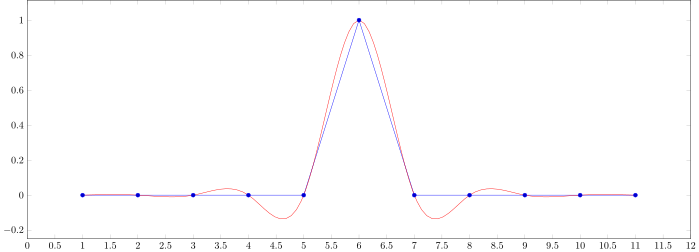

In [57]:
Axis([
        Plots.Linear(pts[1,:],pts[2,:]),
        Plots.Linear(x_arr, y_arr, mark="none")
        ], width="25cm", height="10cm")

In [58]:
t_arr[1], t_arr[end]

(0.0, 10.0)

In [59]:
spline_coeffs[1]

4×10 Array{Float64,2}:
 1.0           2.0          3.0          …   8.0          9.0  10.0        
 1.0           1.0          1.0              1.0          1.0   1.0        
 2.22045e-16   1.11022e-16  2.22045e-16     -4.44089e-16  0.0   1.11022e-16
 0.0          -1.11022e-16  0.0              2.22045e-16  0.0  -1.11022e-16

# Spline Conversions

In [60]:
# 4th order (cubic) B-spline Basis Functions
MB_4 = (1/6) * [
    -1 3 -3 1;
    3 -6 3 0;
    -3 0 3 0;
    1 4 1 0
]
# Cubic Hermite Basis Functions
M_Hermite = [
    
]
# Bezier Basis Functions
MBezier = [
    -1 3 -3 1;
    3 -6 3 0;
    -3 3 0 0;
    1 0 0 0
]
# Catmull Rom Basis Functions
Mcmr = [ 
    -0.5   1.5  -1.5   0.5;
    1.0  -2.5   2.0  -0.5;
    -0.5   0.0   0.5   0.0;
    0.0   1.0   0.0   0.0
];

In [61]:
cpts = [1;1]' .+ [collect(0:.5:10) sin.(2*sqrt.(collect(0:.5:10)))]
PB = cpts
n = size(cpts)[1] - 1
d = 3 # degree
t = collect(linspace(0.0,n+1-d,200))
T = hcat([min.(t,mod1.(t,1.0)).^i for i in reverse(0:3)]...)
spl_pts = zeros(length(t),2)
for i in 1:n+1-d
    spl_pts[(i-1 .<= t .<= i),:] = T[(i-1 .<= t .<= i),:]*MB_4*cpts[i:i+d,:]
end

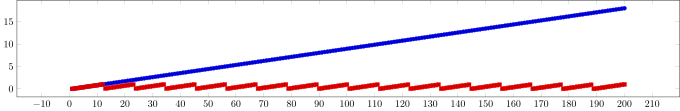

In [62]:
Axis([
        Plots.Linear(collect(1:length(t)),t),
        Plots.Linear(collect(1:length(t)),min.(t,mod1.(t,1.0)))
        ], width="25cm", height="5cm")

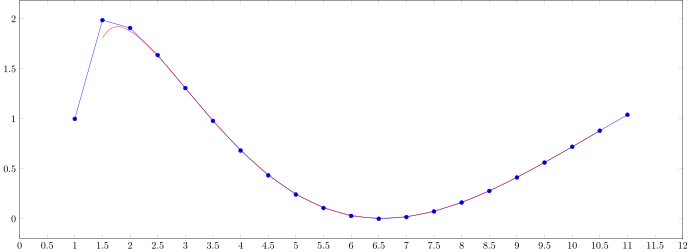

In [64]:
Axis([
        Plots.Linear(cpts[:,1],cpts[:,2]),
        Plots.Linear(spl_pts[:,1],spl_pts[:,2],mark="none")
        ], width="25cm", height="10cm")

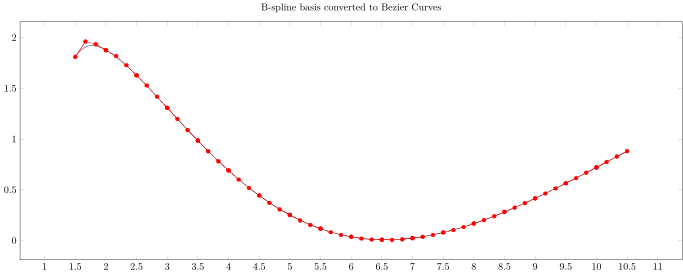

In [29]:
# convert to Bezier
Bezier_cpts = [inv(MBezier)*MB_4*PB[i:i+d,:] for i in 1:n+1-d]
Bezier_pts = zeros(length(t),2)
for i in 1:n+1-d
    pts = inv(MBezier)*MB_4*PB[i:i+d,:]
    Bezier_pts[(i-1 .<= t .<= i),:] = T[(i-1 .<= t .<= i),:]*MBezier*pts
end
A = Axis(width="25cm",height="10cm",title="B-spline basis converted to Bezier Curves")
push!(A,Plots.Linear(Bezier_pts[:,1],Bezier_pts[:,2],mark="none",style="black"))
for pts in Bezier_cpts
    push!(A,Plots.Linear(pts[1:2,1],pts[1:2,2],style=style="red, mark options={fill=red}",mark="*"))
    push!(A,Plots.Linear(pts[3:4,1],pts[3:4,2],style=style="red, mark options={fill=red}",mark="*"))
    push!(A,Plots.Linear(pts[1:4,1],pts[1:4,2],mark="none",style="red"))
end
A

In [30]:
# derivative operator for taking derivative of basis functions
dt = zeros(4,4)
dt[1,1] = 0
dt[2,1] = 3
dt[3,2] = 2
dt[4,3] = 1

1

In [32]:
δt = mean(diff(t))

0.09045226130653267

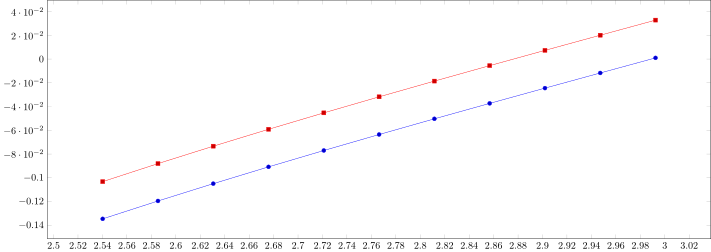

In [33]:
i = 3
pts = T[(i-1 .<= t .<= i),:]*MBezier*Bezier_cpts[i]
dpts = T[(i-1 .<= t .<= i),:]*dt*MBezier*Bezier_cpts[i];
dx = dpts[:,1]
dy = dpts[:,2]
d2pts = T[(i-1 .<= t .<= i),:]*dt*dt*MBezier*Bezier_cpts[i];
d2x = d2pts[:,1]
d2y = d2pts[:,2]
d3pts = T[(i-1 .<= t .<= i),:]*dt*dt*dt*MBezier*Bezier_cpts[i];
d3x = d3pts[:,1]
d3y = d3pts[:,2]

θ = atan2.(dy,dx)
κ = (dx.*d2y .- dy.*d2x)./(dx.*dx .+ dy.*dy).^1.5;
dκ = ((dx.^2 .+ dy.^2).*1.5.*(dx.*d3y .- dy.*d3x) - (dx.*d2y - dy.*d2x).*1.5.*(dx.^2+dy.^2).*2.0.*(d2x.+d2y)) ./ (dx.^2+dy.^2).^3
Axis([
#         Plots.Linear(pts[:,1],pts[:,2])
#         Plots.Linear(pts[:,1],θ)
        Plots.Linear(pts[:,1],κ),
        Plots.Linear(pts[:,1],κ.+dκ*δt)
        ],width="25cm",height="10cm")

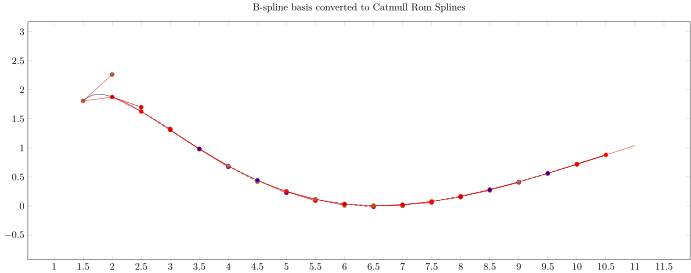

In [34]:
# convert to Bezier
CatmullRom_cpts = [inv(Mcmr)*MB_4*PB[i:i+d,:] for i in 1:n+1-d]
CatmullRom_pts = zeros(length(t),2)
for i in 1:n+1-d
    pts = inv(Mcmr)*MB_4*PB[i:i+d,:]
    CatmullRom_pts[(i-1 .<= t .<= i),:] = T[(i-1 .<= t .<= i),:]*Mcmr*pts
end
A = Axis(width="25cm",height="10cm",axisEqual=true,title="B-spline basis converted to Catmull Rom Splines")
push!(A,Plots.Linear(CatmullRom_pts[:,1],CatmullRom_pts[:,2],mark="none",style="black"))
for pts in CatmullRom_cpts
    p0 = pts[2,:]
    p1 = pts[3,:]
    v0 = .5*(pts[3,:] - pts[1,:])
    v1 = .5*(pts[4,:] - pts[2,:])
    push!(A,Plots.Linear([p0[1];p1[1]],[p0[2];p1[2]],style="red",mark="none"))
    push!(A,Plots.Linear([p0[1];p0[1]+v0[1]],[p0[2];p0[2]+v0[2]],style="red,mark color=red",mark="*"))
    push!(A,Plots.Linear([p1[1];p1[1]+v1[1]],[p1[2];p1[2]+v1[2]],style="red",mark="none"))
#     push!(A,Plots.Linear(pts[1:4,1],pts[1:4,2],mark="*",style="red"))
end
A